In [1]:
%matplotlib inline

In [2]:
from math import log
import operator
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  #中文显示问题

## 计算给定数据集的香农熵

In [3]:
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]    # 最后一列的键值
        if currentLabel not in labelCounts.keys(): 
            labelCounts[currentLabel] = 0    # 扩展字典，加入键值
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    # 计算香农熵
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

## 按给定特征划分数据集
参数列表：待划分的数据集，划分数据集的特征，需要返回的特征的值

In [4]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []    # python传递引用，这里声明新列表消除影响
    for featVec in dataSet:
        if featVec[axis] == value:
            # 抽取缝合特征的数据
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

## 选择最好的数据集划分方式

In [5]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1    # 特征属性的数量
    baseEntropy = calcShannonEnt(dataSet)    # 计算原始香农熵
    bestInfoGain = 0.0
    bestFeature = -1
    # 遍历数据集中的所有特征
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet] 
        uniqueVals = set(featList)    # 创建唯一的分类标签列表
        newEntropy = 0.0
        # 计算每种划分的信息熵
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy    # 计算信息增益
        # 找到信息增益最大的特征
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

## 投票法决定结果

In [6]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        # 创建数据字典
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1    # 每出现一次加一
        # 利用operator操作键值排序字典
        sortedClassCount = sorted(classCount.iteritems(), key = operator.itemgetter(1), reverse = True)
        return sortedClassCount[0][0]

## 创建树 
输入参数：数据集，标签列表

In [7]:
def createTree(dataSet, labels):
    classList =[example[-1] for example in dataSet]    # 数据集的所有类标签
    if classList.count(classList[0]) == len(classList):    # 类标签完全相同则停止
        return classList[0]
    if len(dataSet[0]) == 1:    # 用完了所有特征
        return majorityCnt(classList)    # 投票法决定
    bestFeat = chooseBestFeatureToSplit(dataSet)    
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}    # 存储树的所有信息，选取最好的特征存入树中
    labels2 = labels[:]
    del(labels2[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    # 遍历当前选择特征包含的所有属性值
    for value in uniqueVals:
        subLabels = labels2[:]    # 复制类标签，防止原内容改变
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

## 绘制树节点

In [8]:
# 定义文本框和箭头样式
decisionNode = dict(boxstyle = "sawtooth", fc = "0.8")
leafNode = dict(boxstyle = "round4", fc = "0.8")
arrow_args = dict(arrowstyle = "<-")
# 绘制带箭头的注解
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.axl.annotate(nodeTxt, xy = parentPt, xycoords = 'axes fraction',xytext = centerPt, textcoords='axes fraction',\
                           va = "center", ha = "center",bbox = nodeType, arrowprops = arrow_args)
    
# 获取叶结点的数目
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

# 获取树的层数
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

# 在父子节点间填充文本信息
def plotMinText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.axl.text(xMid, yMid, txtString)
    
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)    # 计算宽
    depth = getTreeDepth(myTree)    # 计算高
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    # 标记子节点属性值
    plotMinText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    # 减少y偏移
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMinText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks = [], yticks = [])
    createPlot.axl = plt.subplot(111, frameon = False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))    # 树的宽
    plotTree.totalD = float(getTreeDepth(inTree))    # 树的高
    plotTree.xOff = - 0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

## 分类函数

In [9]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

## 使用pickle模块存储决策树

In [10]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

## 使用决策树预测隐形眼镜类型

In [11]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]    # 解析tab分隔数据行
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)

In [12]:
lensesTree

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'pre': 'no lenses',
        'young': 'hard',
        'presbyopic': 'no lenses'}}}},
    'no': {'age': {'pre': 'soft',
      'young': 'soft',
      'presbyopic': {'prescript': {'myope': 'no lenses',
        'hyper': 'soft'}}}}}}}}

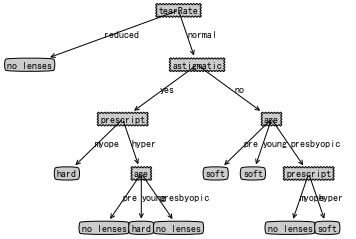

In [13]:
createPlot(lensesTree)

## 使用决策树模型进行预测

In [14]:
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
classify(lensesTree, lensesLabels, lenses[0][:-1])

'no lenses'